In [1]:
# Step 0. Import libraries and custom modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
# Preprocessing --------------------------------------------------------
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Metrics --------------------------------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Interpreting ---------------------------------------------------------
import shap
# Exporting ------------------------------------------------------------
import pickle
# Supress FutureWarning ------------------------------------------------
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Step 1. Read the dataset
# The data this week comes from Coffee Quality Database courtesy of Buzzfeed Data Scientist 
# James LeDoux. The original data can be found on James' github. The data was re-posted to Kaggle.
# These data were collected from the Coffee Quality Institute's review pages in January 2018.
# There is data for both Arabica and Robusta beans, across many countries and professionally 
# rated on a 0-100 scale. All sorts of scoring/ratings for things like acidity, sweetness, fragrance, 
# balance, etc - may be useful for either separating into visualizations/categories or for 
# modeling/recommenders.
# https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-07-07/readme.md
url = 'https://raw.githubusercontent.com/rfordatascience/' + \
'tidytuesday/master/data/2020/2020-07-07/coffee_ratings.csv'
df_raw = pd.read_csv(url)
df_raw.to_csv('../data/raw/coffee.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_cup_points       1339 non-null   float64
 1   species                1339 non-null   object 
 2   owner                  1332 non-null   object 
 3   country_of_origin      1338 non-null   object 
 4   farm_name              980 non-null    object 
 5   lot_number             276 non-null    object 
 6   mill                   1021 non-null   object 
 7   ico_number             1180 non-null   object 
 8   company                1130 non-null   object 
 9   altitude               1113 non-null   object 
 10  region                 1280 non-null   object 
 11  producer               1107 non-null   object 
 12  number_of_bags         1339 non-null   int64  
 13  bag_weight             1339 non-null   object 
 14  in_country_partner     1339 non-null   object 
 15  harv

In [3]:
# 1.1 Get a sample
df_raw.sample(10)

,total_cup_points,species,owner,country_of_origin,farm_name,lot_number,mill,ico_number,company,altitude,...,color,category_two_defects,expiration,certification_body,certification_address,certification_contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
452,83.17,Arabica,taylor winch (coffee) ltd.,Kenya,NaN,NaN,NaN,37-0843-3305,taylor winch (coffee) ltd,approx.1'500 metres a.s.l.,...,Bluish-Green,1,"July 2nd, 2016",Kenya Coffee Traders Association,ccba45b89d859740b749878be8c6d16fbdb96c2e,d752c909a015f3c76224b3c5cc520f8a67afda74,m,1.0,500.0,250.5
63,85.58,Arabica,lusso lab,El Salvador,finca la esmeralda,NaN,"aqua caliente, j.j. borja nathan. s.a",NaN,lusso coffee lab,1300~1400 m.s.l,...,NaN,0,"January 12th, 2014",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1300.0,1400.0,1350.0
733,82.33,Arabica,carcafe ltda ci,Colombia,NaN,NaN,NaN,3-59-0787,carcafe ltda,442 msnm,...,Green,0,"January 30th, 2013",Almacafé,e493c36c2d076bf273064f7ac23ad562af257a25,70d3c0c26f89e00fdae6fb39ff54f0d2eb1c38ab,m,442.0,442.0,442.0
710,82.33,Arabica,rodrigo soto,Costa Rica,rio jorco,Tarrazu,rio jorco,5/423/0127,panamerican coffee trading,1550,...,Green,0,"May 17th, 2017",Specialty Coffee Association of Costa Rica,8e0b118f3cf3121ab27c5387deacdb7d4d2a60b1,5eb2b7129d9714c43825e44dc3bca9423de209e9,m,1550.0,1550.0,1550.0
255,84.00,Arabica,taylor winch (coffee) ltd.,Kenya,-,NaN,NaN,37-0569-2347,taylor winch (coffee) ltd,1650,...,Bluish-Green,0,"May 31st, 2013",Kenya Coffee Traders Association,ccba45b89d859740b749878be8c6d16fbdb96c2e,d752c909a015f3c76224b3c5cc520f8a67afda74,m,1650.0,1650.0,1650.0
1103,80.25,Arabica,the coffee source inc.,Guatemala,several,NaN,ixchel,11-23-1972,the coffee source inc.,1400,...,Green,12,"January 9th, 2014",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1400.0,1400.0,1400.0
1235,78.00,Arabica,"lin, che-hao krude 林哲豪",Taiwan,大鋤花間 (hoe vs. flower coffee farm),2017台南市精品咖啡評鑑批次 Specialty Coffee Evaluation of...,大鋤花間 (hoe vs. flower coffee farm),Taiwan,taiwan coffee laboratory,650,...,Green,4,"June 6th, 2018",Specialty Coffee Association,36d0d00a3724338ba7937c52a378d085f2172daa,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,650.0,650.0,650.0
382,83.42,Arabica,consejo salvadoreño del café,El Salvador,la joya,73,el borbollon,9-391-73,consejo salvadoreño del café,1330,...,NaN,0,"April 25th, 2017",Salvadoran Coffee Council,3d4987e3b91399dbb3938b5bdf53893b6ef45be1,27b21e368fb8291cbea02c60623fe6c98f84524d,m,1330.0,1330.0,1330.0
779,82.08,Arabica,ipanema coffees,Brazil,fazenda capoeirnha,007/16B,dry mill,002/1660/0105,ipanema coffees,894,...,Green,3,"August 16th, 2017",Brazil Specialty Coffee Association,3297cfa4c538e3dd03f72cc4082c54f7999e1f9d,8900f0bf1d0b2bafe6807a73562c7677d57eb980,m,894.0,894.0,894.0
893,81.67,Arabica,miguel cortes moreno,Mexico,sacún palma,NaN,sacún palma,1,"estrategias constructivas corzu, s.a. de c.v.",940,...,Green,4,"February 28th, 2013",AMECAFE,59e396ad6e22a1c22b248f958e1da2bd8af85272,0eb4ee5b3f47b20b049548a2fd1e7d4a2b70d0a7,m,940.0,940.0,940.0


In [4]:
# 1.2 Transform data
# Select metrics
df_interim = df_raw.copy()
# Select columns
df_interim = df_interim[['total_cup_points',
                         'species',
                         'country_of_origin',
                         'variety',
                         'aroma',
                         'aftertaste',
                         'acidity',
                         'body',
                         'balance',
                         'sweetness',
                         'altitude_mean_meters',
                         'moisture']]
df_interim = df_interim.dropna()
# Categorize data
df_interim['species'] = pd.Categorical(df_interim['species'])
df_interim['country_of_origin'] = pd.Categorical(df_interim['country_of_origin'])
df_interim['variety'] = pd.Categorical(df_interim['variety'])
# Specialty coffee are over 80 points, https://nobletreecoffee.com/coffee-cupping/
df_interim['specialty'] = df_interim['total_cup_points'].apply(lambda x: 'Yes' if x>80 else 'No')
# Limit categories based on pareto rules
top_varieties = ['Caturra','Typica','Bourbon','Catuai']
df_interim['variety'] = df_interim['variety'].\
    apply(lambda x: x if x in top_varieties else 'Other')
top_countries = ['Mexico','Guatemala','Colombia','Brazil','Taiwan']
df_interim['country_of_origin'] = df_interim['country_of_origin'].\
    apply(lambda x: x if x in top_countries else 'Other')
df_interim['country_of_origin'] = pd.Categorical(df_interim['country_of_origin'])
df_interim['variety'] = pd.Categorical(df_interim['variety'])
df_interim['specialty'] = df_interim['total_cup_points'].apply(lambda x: 'Yes' if x>82.43 else 'No')
df_interim['specialty'] = pd.Categorical(df_interim['specialty'])
# Save into data folder
df_interim.to_csv('../data/interim/coffee_model_interim.csv')
# Create final file
df = df_interim.copy()

In [5]:
# 2. EDA
# Create train and test sets
X = df.drop(['specialty','total_cup_points','species','altitude_mean_meters','sweetness'], axis=1)
y = df['specialty']
X_train, X_test, y_train, y_test = train_test_split(X, y , stratify=y, random_state=123)
df_train = pd.concat([X_train, y_train], axis=1)
# Save train model for data exploration
df_train.to_csv('../data/final/coffee_model_final.csv')

In [6]:
# 2.1 Get info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 780 to 911
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country_of_origin  747 non-null    category
 1   variety            747 non-null    category
 2   aroma              747 non-null    float64 
 3   aftertaste         747 non-null    float64 
 4   acidity            747 non-null    float64 
 5   body               747 non-null    float64 
 6   balance            747 non-null    float64 
 7   moisture           747 non-null    float64 
 8   specialty          747 non-null    category
dtypes: category(3), float64(6)
memory usage: 43.6 KB


In [7]:
# 2.2 Get stats
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country_of_origin,747,6,Other,248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,747,5,Other,213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aroma,747.0,NaN,NaN,NaN,7.56585,0.310261,5.08,7.42,7.58,7.75,8.75
aftertaste,747.0,NaN,NaN,NaN,7.386948,0.337051,6.17,7.17,7.42,7.58,8.5
acidity,747.0,NaN,NaN,NaN,7.525877,0.313565,5.25,7.33,7.5,7.67,8.58
body,747.0,NaN,NaN,NaN,7.509652,0.271466,6.42,7.33,7.5,7.67,8.42
balance,747.0,NaN,NaN,NaN,7.497617,0.341907,6.08,7.33,7.5,7.67,8.58
moisture,747.0,NaN,NaN,NaN,0.094177,0.044333,0.0,0.1,0.11,0.12,0.17
specialty,747,2,No,377,NaN,NaN,NaN,NaN,NaN,NaN,NaN


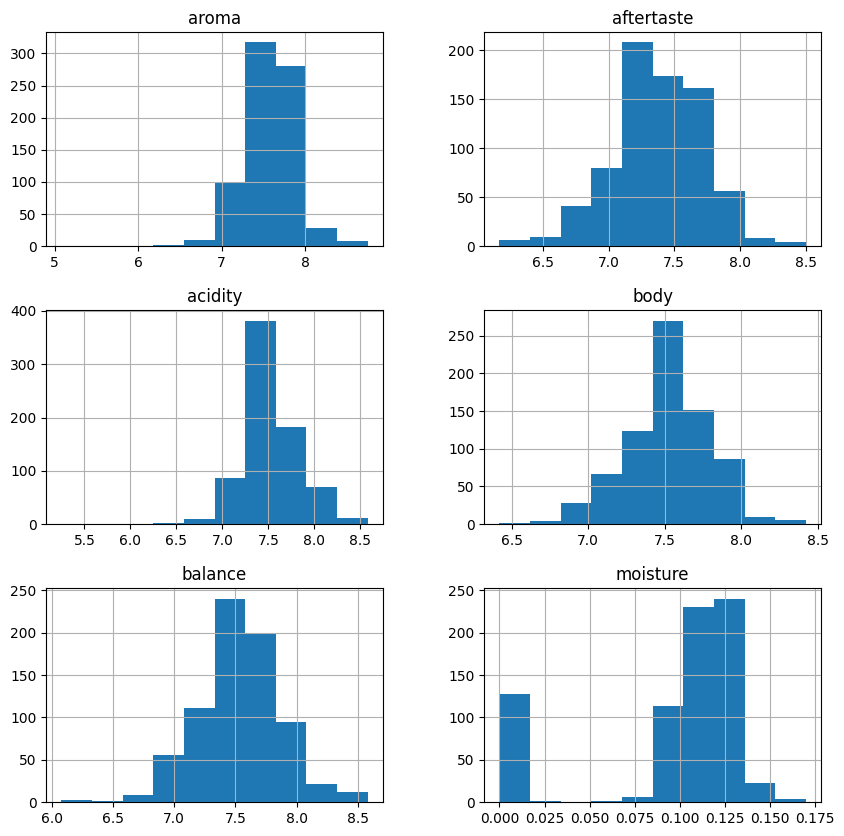

In [8]:
# 2.3 Plot histograms for univariate analysis on numerical values
df_train.hist(figsize=(10,10))
plt.show()

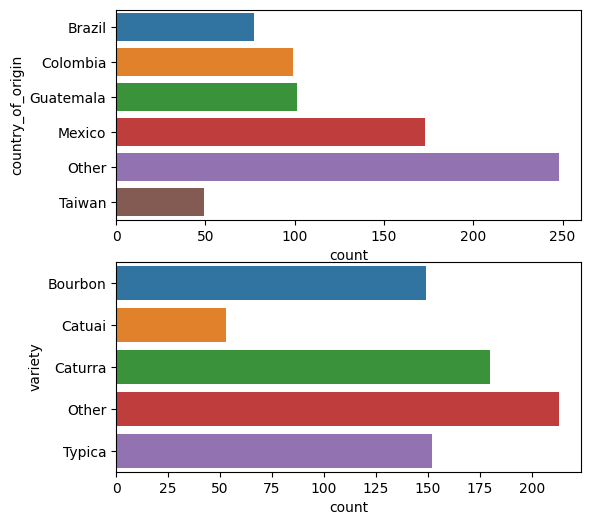

In [9]:
# 2.4 Plot categories countplot for univariate analysis on categorical data
cats = X_train.select_dtypes('category')
fig, ax = plt.subplots(2,1, figsize=(6,6))
axs = ax.flatten()
for i in range(len(axs)):
    sns.countplot(data=cats, y=cats.columns.to_list()[i], ax=axs[i])

The figure layout has changed to tight


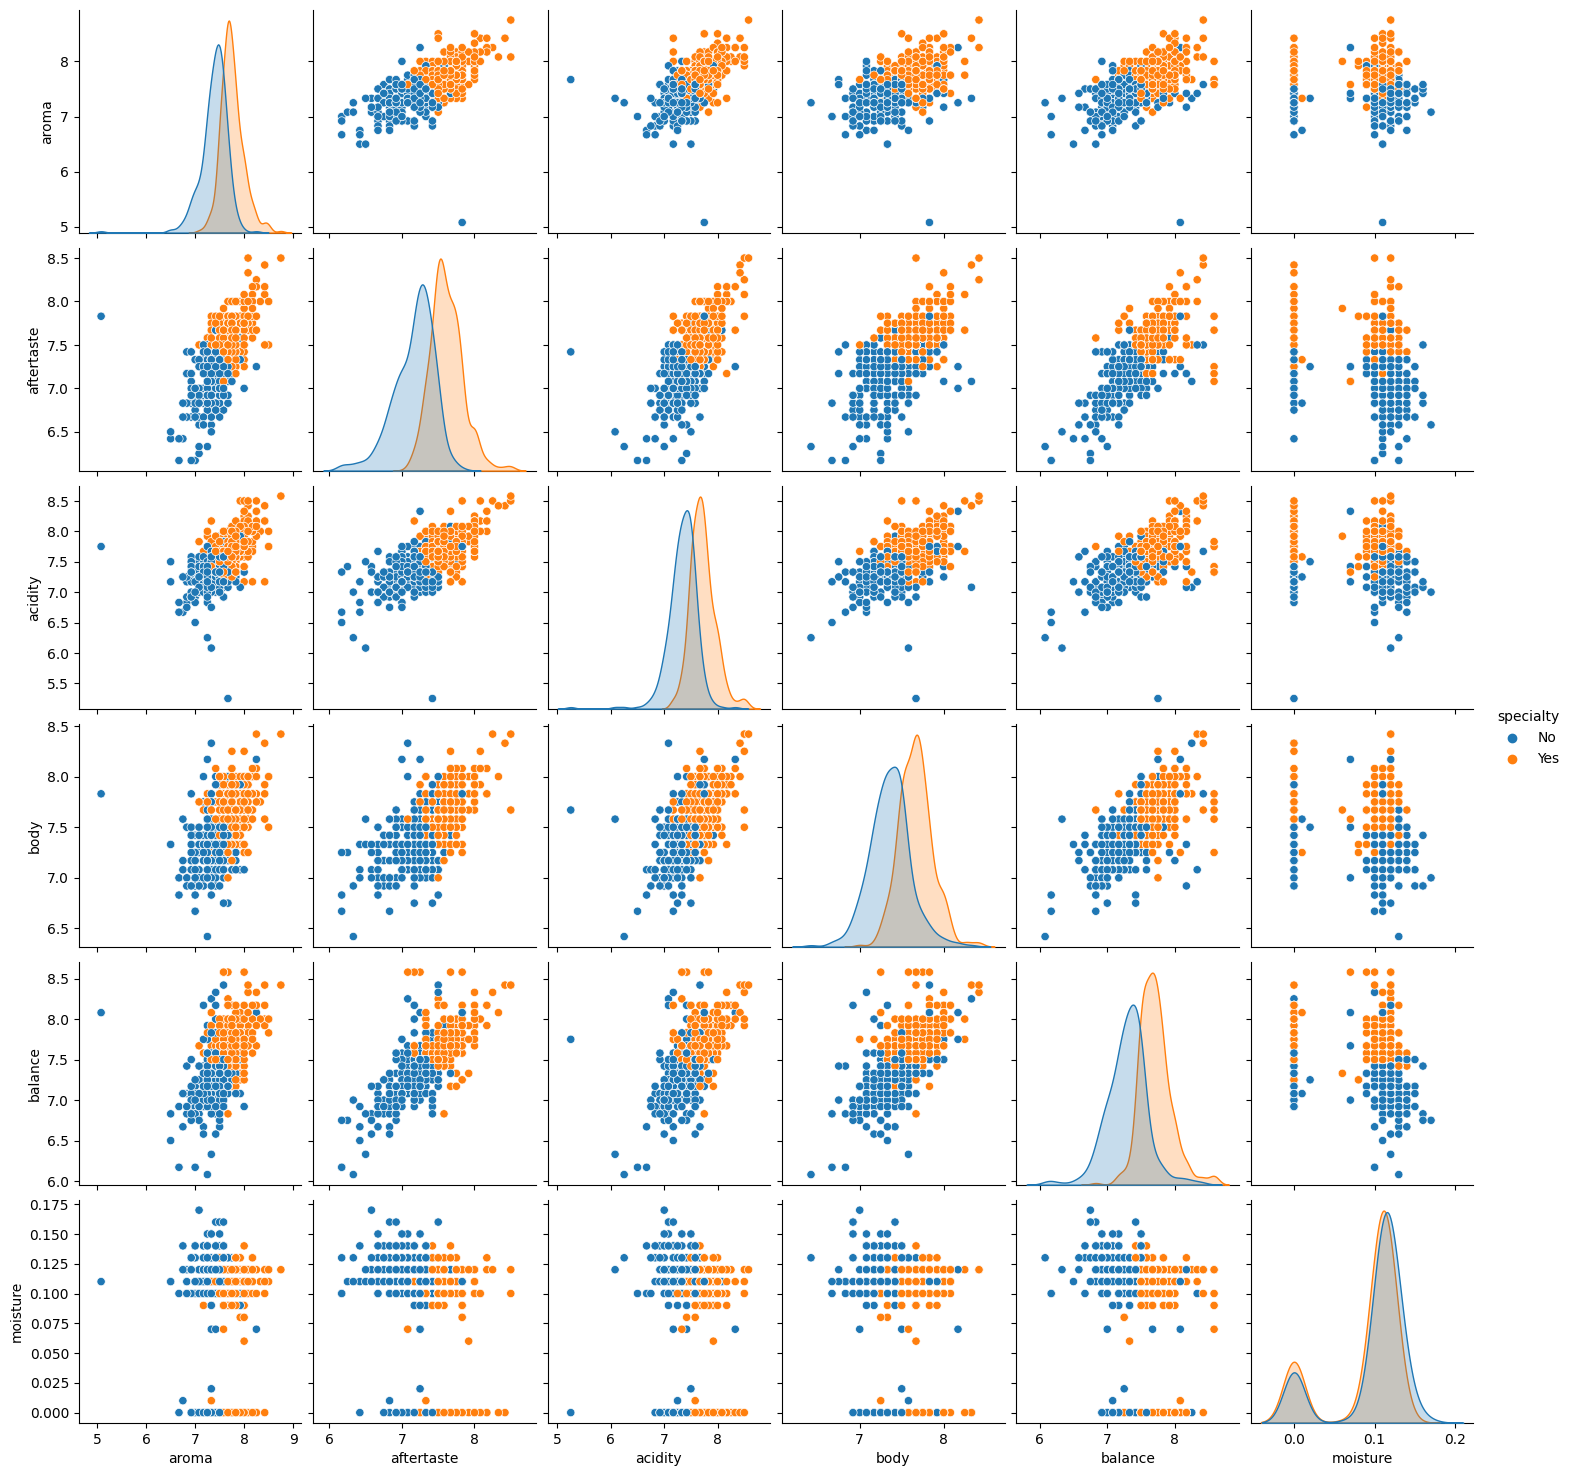

In [10]:
# 2.5 Plot pairplot for bivariate analysis
sns.pairplot(data=df_train, hue='specialty')
plt.show()

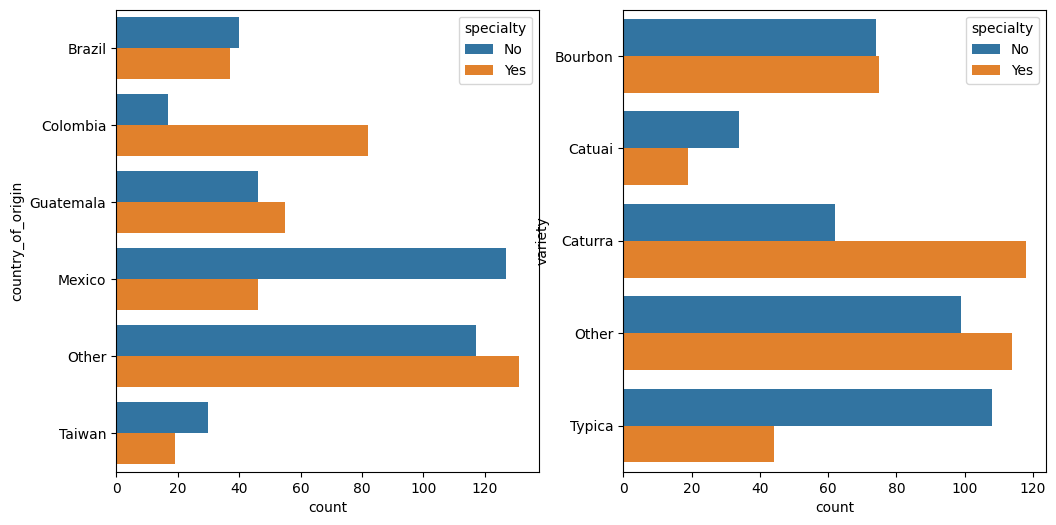

In [11]:
# 2.6 Plot category effect
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.countplot(data=df_train, y='country_of_origin', hue='specialty', ax=ax[0])
sns.countplot(data=df_train, y='variety', hue='specialty', ax=ax[1])
plt.show()

In [12]:
# 2.7 Calculate correlation
X_train.select_dtypes('number').corr().style.background_gradient(cmap='Blues')

,aroma,aftertaste,acidity,body,balance,moisture
aroma,1.000000,0.675971,0.586244,0.523622,0.588692,-0.038481
aftertaste,0.675971,1.000000,0.680573,0.668489,0.768697,-0.139767
acidity,0.586244,0.680573,1.000000,0.604851,0.638995,-0.084052
body,0.523622,0.668489,0.604851,1.000000,0.688455,-0.178684
balance,0.588692,0.768697,0.638995,0.688455,1.000000,-0.197440
moisture,-0.038481,-0.139767,-0.084052,-0.178684,-0.197440,1.000000


In [13]:
# 3. Create the prediction model
# 3.1 Create your pipeline processing
# https://stackoverflow.com/questions/61641852/
# https://jaketae.github.io/study/sklearn-pipeline/
cat_cols = X_train.select_dtypes(include='category').columns
num_cols = X_train.select_dtypes(include='number').columns

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False))
])

num_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers = [
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

In [14]:
# 3.2 Perform model fit
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())])

pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['aroma', 'aftertaste', 'acidity', 'body', 'balance', 'moisture'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index(['country_of_origin', 'variety'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

              precision    recall  f1-score   support

          No       0.93      0.91      0.92       126
         Yes       0.91      0.94      0.92       124

    accuracy                           0.92       250
   macro avg       0.92      0.92      0.92       250
weighted avg       0.92      0.92      0.92       250



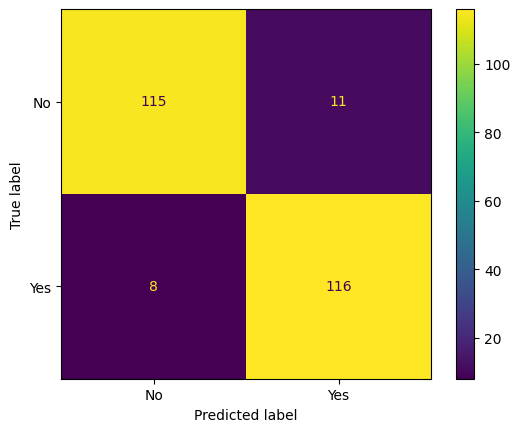

In [15]:
# 3.3 Predict and calculate metrics using the confusion matrix
y_hat = pipe_rf.predict(X_test)
print(classification_report(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=pipe_rf.classes_).plot()
plt.show()

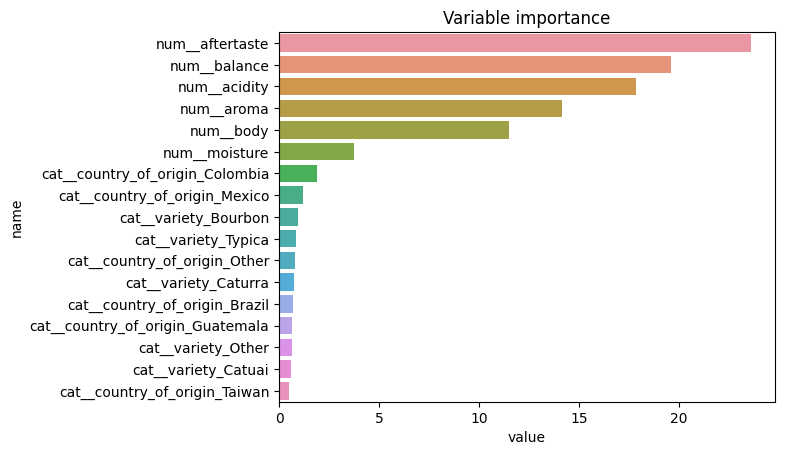

In [16]:
var_imp = pd.DataFrame({'name':pipe_rf['preprocessor'].get_feature_names_out(),
                        'value':pipe_rf['classifier'].feature_importances_ *100}).sort_values(by='value', ascending=False)
sns.barplot(data=var_imp, x='value',y='name')
plt.title('Variable importance')
plt.show()


In [17]:
# 3.4 Save the model as a pickle
filename = '../model/coffee_model.pkl'
pickle.dump(pipe_rf, open(filename,'wb'))

In [19]:
X_train.head(1)

,country_of_origin,variety,aroma,aftertaste,acidity,body,balance,moisture
780,Brazil,Other,7.25,7.58,7.58,7.25,7.92,0.0
